#Object Detection Framework

In [0]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/PramukaWeerasinghe/object_detection_demo'

# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `object_detection_demo` repository or your fork.

In [65]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
fatal: destination path 'object_detection_demo' already exists and is not an empty directory.
/content/object_detection_demo
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/PramukaWeerasinghe/object_detection_demo
   ed6d023..60c483b  master     -> origin/master
Updating ed6d023..60c483b
Fast-forward
 tensorflow_object_detection_training_colab.ipynb | 2481 ++++++++++++----------
 1 file changed, 1389 insertions(+), 1092 deletions(-)


In [3]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


## Install required packages

In [4]:
%cd /content
!git clone https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] = '/content/models/research:/content/models/research/slim:' + os.environ['PYTHONPATH']

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_confi

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [5]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/object_detection_demo
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.

W0401 08:02:17.832768 140076702865280 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/annotations/train.record

W0401 08:02:21.956411 140065669502848 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/annotations/test.record


In [0]:
test_record_fname = '/content/object_detection_demo/data/annotations/test.record'
train_record_fname = '/content/object_detection_demo/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/data/annotations/label_map.pbtxt'

## Download base model

In [7]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [8]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 65 root   root 4.0K Apr  1 08:02 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [9]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [12]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [13]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 4
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [0]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [15]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-04-01 08:03:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.3.79.57, 52.203.240.15, 34.202.138.174, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.3.79.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  14.4MB/s    in 0.9s    

2020-04-01 08:03:36 (14.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [18]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a3caeb4f.ngrok.io


## Train the model

In [19]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0401 08:04:14.378720 139811302528896 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0401 08:04:14.381437 139811302528896 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0401 08:04:14.381569 139811302528896 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0401 08:04:14.381757 139811302528896 module_wrapper.py:139] From /content/models/resea

In [20]:
!ls {model_dir}

checkpoint				     model.ckpt-0.meta
events.out.tfevents.1585728277.b5dad5acaa27  model.ckpt-573.data-00000-of-00001
graph.pbtxt				     model.ckpt-573.index
model.ckpt-0.data-00000-of-00001	     model.ckpt-573.meta
model.ckpt-0.index


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [21]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-573
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0401 08:18:04.097018 140031227590528 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0401 08:18:04.105122 140031227590528 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0401 08:18:04.105453 140031227590528 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.comp

In [23]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [26]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 50M Apr  1 08:18 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [27]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1OZsk59xIYVUExjchm7mN4NZEZfa-k7zE


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [28]:
from google.colab import files
files.download(pb_fname)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 56400, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

### Download the `label_map.pbtxt` file

In [0]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [0]:
files.download(pipeline_fname)

## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [66]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/test/0.jpg']


In [32]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (28.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [61]:
%cd /content/object_detection_demo/
import wabtec_track

/content/object_detection_demo


/content/models/research/object_detection


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:317: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

            type          id                       milepost
0         switch           —                    M.P. 8.0764
1    left Signal          N=  M.P. 8.1144\nM.P. 8.1146¢(4N}
2    left Signal         2I—  M.P. 8.1144\nM.P. 8.1146¢(4N}
3    left Signal              M.P. 8.1144\nM.P. 8.1146¢(4N}
4   right Signal  2 owit\nTe                   M.-P. 7.9131
5   right Signal        — 4S                   M.-P. 7.9131
6         switch                                M.P. 8.0172
7    left Signal          N=  M.P. 8.1144\nM.P. 8.1146¢(4N}
8    left Signal         2I—  M.P. 8.1144\nM.P. 8.1146¢(4N}
9    left Signal              M.P. 8.1144\nM.P. 8.1146¢(4N}
10  right Signal  2 owit\nTe                   M.-P. 7.9131
11  right Signal        — 4S                   M.-P. 7.9131
12        switch                                M.P. 8.0538
13   left Signal          N=  M.P. 8.1144\nM.P. 8.1146¢(4N}
14   left Signal         2I—  M.P. 8.1144\nM.P. 8.1146¢(4N}
15   left Signal              M.P. 8.114

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


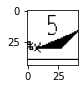

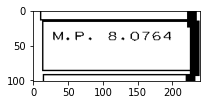

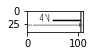

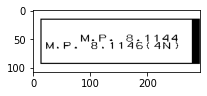

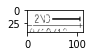

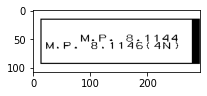

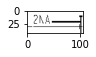

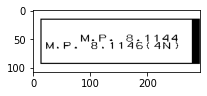

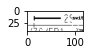

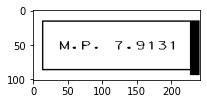

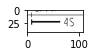

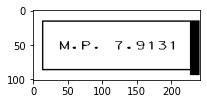

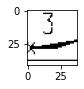

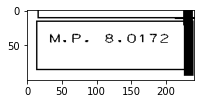

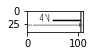

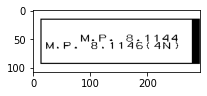

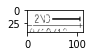

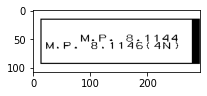

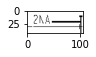

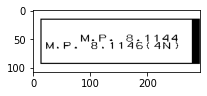

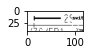

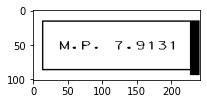

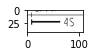

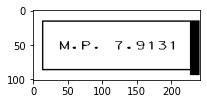

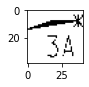

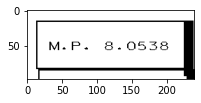

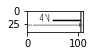

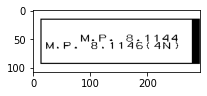

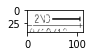

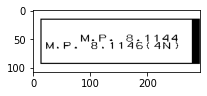

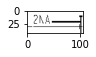

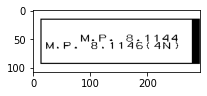

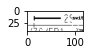

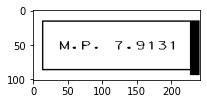

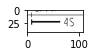

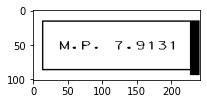

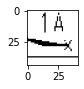

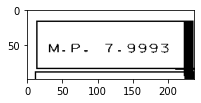

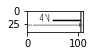

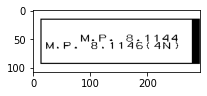

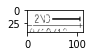

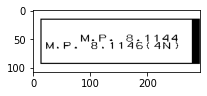

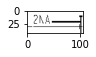

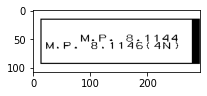

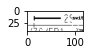

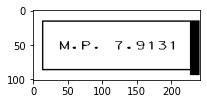

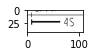

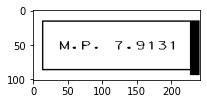

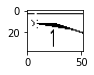

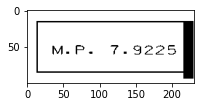

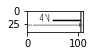

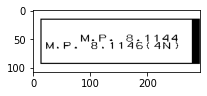

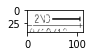

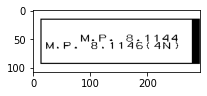

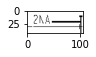

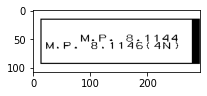

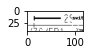

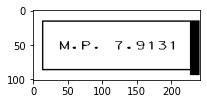

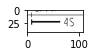

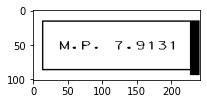

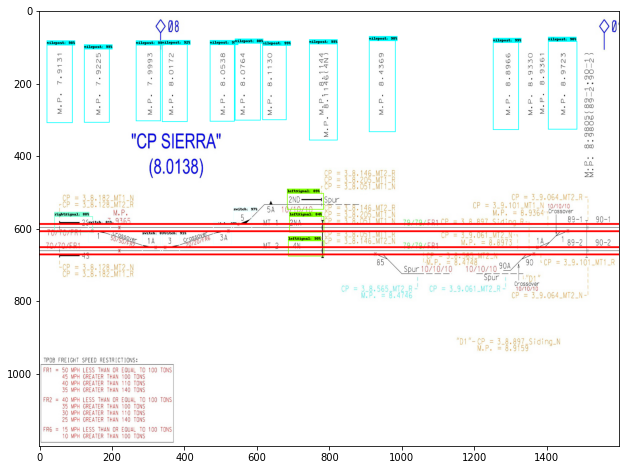

In [99]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import pytesseract
from pytesseract import Output
import shutil
import cv2
import zipfile
import pandas as pd
import wabtec_track

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import files

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    colors = []

    for c in output_dict['detection_classes']:
      if(c==1):
        colors.append(13)
      if(c==2):
        colors.append(90)
      if(c==3):
        colors.append(25)
      if(c==4):
        colors.append(13)
    
    #track_ids=colors,

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
  
    boxes = np.squeeze(output_dict['detection_boxes'])
    scores = np.squeeze(output_dict['detection_scores'])
    classes = np.squeeze(output_dict['detection_classes'])
    #set a min thresh score, say 0.8
    min_score_thresh = 0.3
    bboxes = boxes[scores > min_score_thresh]
    d_classes = classes[scores > min_score_thresh]
    switch_boxes = bboxes[d_classes == 4]
    milepost_boxes = bboxes[d_classes == 2]
    left_signal_boxes = bboxes[d_classes == 1]
    right_signal_boxes = bboxes[d_classes == 3]

    #get image size
    im_width, im_height = image.size
    # print(image_np.shape)
    # print(image.size)
    final_box = []
    for box in bboxes:
        ymin, xmin, ymax, xmax = box
        final_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
    #print(final_box)

    sw_box = []
    for box in switch_boxes:
        ymin, xmin, ymax, xmax = box
        sw_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
    
    ls_box = []
    for box in left_signal_boxes:
        ymin, xmin, ymax, xmax = box
        ls_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
    rs_box = []
    for box in right_signal_boxes:
        ymin, xmin, ymax, xmax = box
        rs_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])

    m_box = []
    for box in milepost_boxes:
        ymin, xmin, ymax, xmax = box
        m_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])

    
    s_id = []
    milepost = []
    s_type = []

    #switch
    for box in sw_box:
      ymin, xmin, ymax, xmax = box
      y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
      # print(y,h,x,w)
      # print(ymin,xmin)
      crop_img = image_np[h+5:w-5,y+5:x-5]
      plt.figure(figsize=(1,1))
      gray = cv2.cvtColor(crop_img,cv2.COLOR_RGB2GRAY)
      kernel = np.ones((3,3),np.uint8)
      im = np.array(gray * 255, dtype = np.uint8)
      (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      dilation = cv2.dilate(gray,kernel,iterations = 1)
      #opened = cv2.dilate(thresh, kernel, iterations = 1)
      custom_config = r'--oem 3 --psm 6'
      img = Image.fromarray(dilation)
      sid = pytesseract.image_to_string(img, config=custom_config)
      #print(sid)
      
      plt.imshow(gray,cmap='gray') 
      #print(pytesseract.image_to_string((crop_img)))
      #plt.imshow(crop_img) 
      for b in m_box:
          ymin, xmin, ymax, xmax = b
          a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
          val = (y+x)/2
          if(a<val and val<c ):
             crop_ml = image_np[b-15:d+15,a-15:c+15]
             r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
             plt.figure(figsize=(3,6))
             gray = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)
             kernel = np.ones((3,3),np.uint8)
             im = np.array(gray * 255, dtype = np.uint8)
             (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
             #opened = cv2.dilate(thresh, kernel, iterations = 1)
             custom_config = r'--oem 3 --psm 6'
             img = Image.fromarray(gray)
             milestone_id = pytesseract.image_to_string(img, config=custom_config)
             #print(pytesseract.image_to_string(img, config=custom_config))
             milepost.append(milestone_id)
             s_id.append(sid)
             s_type.append("switch")
             plt.imshow(img,cmap='gray') 
      #left signal
      for box in ls_box:
        ymin, xmin, ymax, xmax = box
        y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
        # print(y,h,x,w)
        # print(ymin,xmin)
        crop_img = image_np[h:w,y-10:x]
        plt.figure(figsize=(1,1))
        gray = cv2.cvtColor(crop_img,cv2.COLOR_RGB2GRAY)
        kernel = np.ones((3,3),np.uint8)
        im = np.array(gray * 255, dtype = np.uint8)
        (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        #opened = cv2.dilate(thresh, kernel, iterations = 1)
        custom_config = r'--oem 3 --psm 6'
        img = Image.fromarray(gray)
        sid = pytesseract.image_to_string(img, config=custom_config)
        #print(sid)
        
        plt.imshow(img,cmap='gray') 
        #print(pytesseract.image_to_string((crop_img)))
        #plt.imshow(crop_img) 
        for b in m_box:
            ymin, xmin, ymax, xmax = b
            a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
            val = x-5
            if(a<val and val<c ):
              crop_ml = image_np[b-15:d+15,a-15:c+15]
              r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
              plt.figure(figsize=(3,6))
              gray = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)
              kernel = np.ones((3,3),np.uint8)
              im = np.array(gray * 255, dtype = np.uint8)
              (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
              #opened = cv2.dilate(thresh, kernel, iterations = 1)
              custom_config = r'--oem 3 --psm 6'
              img = Image.fromarray(gray)
              milestone_id = pytesseract.image_to_string(img, config=custom_config)
              #print(pytesseract.image_to_string(img, config=custom_config))
              s_id.append(sid)
              s_type.append("left Signal")
              milepost.append(milestone_id)
              plt.imshow(img,cmap='gray')
      #right signal
      for box in rs_box:
        ymin, xmin, ymax, xmax = box
        y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
        # print(y,h,x,w)
        # print(ymin,xmin)
        crop_img = image_np[h:w,y:x+10]
        plt.figure(figsize=(1,1))
        gray = cv2.cvtColor(crop_img,cv2.COLOR_RGB2GRAY)
        kernel = np.ones((3,3),np.uint8)
        im = np.array(gray * 255, dtype = np.uint8)
        (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        #opened = cv2.dilate(thresh, kernel, iterations = 1)
        custom_config = r'--oem 3 --psm 6'
        img = Image.fromarray(gray)
        sid = pytesseract.image_to_string(img, config=custom_config)
        #print(sid)
        
        plt.imshow(img,cmap='gray') 
        #print(pytesseract.image_to_string((crop_img)))
        #plt.imshow(crop_img) 
        for b in m_box:
            ymin, xmin, ymax, xmax = b
            a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
            val = y+5
            if(a<val and val<c ):
              crop_ml = image_np[b-15:d+15,a-15:c+15]
              r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
              plt.figure(figsize=(3,6))
              gray = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)
              kernel = np.ones((3,3),np.uint8)
              im = np.array(gray * 255, dtype = np.uint8)
              (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
              #opened = cv2.dilate(thresh, kernel, iterations = 1)
              custom_config = r'--oem 3 --psm 6'
              img = Image.fromarray(gray)
              milestone_id = pytesseract.image_to_string(img, config=custom_config)
              #print(pytesseract.image_to_string(img, config=custom_config))
              s_id.append(sid)
              s_type.append("right Signal")
              milepost.append(milestone_id)
              plt.imshow(img,cmap='gray')


    dict = {'type': s_type, 'id':s_id, 'milepost':milepost}
    df = pd.DataFrame(dict)
    print(df)
    df.to_csv ('df.csv', index = False, header=True)
    files.download('df.csv') 
    
      # print("lengths")
      # print(len(s_id),len(s_type),len(milepost))
     
    t_img = cv2.imwrite('color_img.jpg', image_np)
    wtt = wabtec_track.WabTecTrack(file_name='color_img.jpg')
    tracks = wtt.get_lines()  
    for track in tracks:
      (x1,y1) = track.point_one()
      (x2,y2) = track.point_two()
      cv2.rectangle(image_np, (x1-10, y1-10), (x2+10, y2+10), (255, 0, 0), 2)
      print(x1,y1,x2,y2)
      
      
       
    print(category_index)
    #print(d_classes)
    #print(m_box)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
